In [1]:
import os
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import matplotlib.colors as mcolors
colors = [(0, 0, 0), (1, 1, 0)]  # Black -> Yellow
black_to_yellow = mcolors.LinearSegmentedColormap.from_list('black_to_yellow', colors)

def plot_kymograph_cells_interest(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, track_id_col='track_id', cell_id_to_color=None):
    fig, ax = plt.subplots(2, 1, figsize=(40, 10))

    kymograph_shape = phase_kymograph.shape
    combined_mask = _create_combined_mask(full_region_df, kymograph_shape)
    
    masked_phase_kymograph = phase_kymograph * combined_mask
    masked_fluor_kymograph = fluor_kymograph * combined_mask
    
    ax[0].imshow(masked_phase_kymograph, cmap='grey')
    _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col='centroid_y', x_coord_col='centroid_x', lineage_col=track_id_col, cell_id_to_color=cell_id_to_color)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    ax[1].imshow(masked_fluor_kymograph, cmap= black_to_yellow)
    _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col='centroid_y', x_coord_col='centroid_x', lineage_col=track_id_col, cell_id_to_color=cell_id_to_color)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    plt.xlabel("Time frames", fontsize = 20)
    plt.tight_layout()


def _create_combined_mask(full_region_df, kymograph_shape):
    """
    Creates a single binary mask for the entire kymograph, combining all cell masks.
    """
    combined_mask = np.zeros(kymograph_shape, dtype=bool)
    for _, region_props in full_region_df.iterrows():
        # Check if the 'coords' column exists and is not empty
        if 'coords' in region_props and region_props['coords'] is not None and len(region_props['coords']) > 0:
            cell_pixel_coords = np.array(region_props['coords'])
            rows = cell_pixel_coords[:, 0]
            cols = cell_pixel_coords[:, 1]
            combined_mask[rows, cols] = True
    return combined_mask


def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = None, cell_id_to_color=None):
    default_cell_contour_color = 'gray'
    text_color = 'white'
    text_offset_x = 5
    text_offset_y = 0

    all_contours_segments = []
    all_contour_colors = []
    all_text_params = []

    for _, region_props in full_region_df.iterrows():
        if not ('coords' in region_props and region_props['coords'] is not None and len(region_props['coords']) > 0):
            continue
        
        cell_pixel_coords = np.array(region_props['coords'])
        
        min_row, min_col = np.min(cell_pixel_coords, axis=0)
        max_row, max_col = np.max(cell_pixel_coords, axis=0)
        buffer = 1
        bbox_min_row = max(0, min_row - buffer)
        bbox_min_col = max(0, min_col - buffer)
        bbox_max_row = min(kymograph_shape[0], max_row + buffer)
        bbox_max_col = min(kymograph_shape[1], max_col + buffer)
        
        temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
        temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)
        
        relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
        relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
        temp_mask[relative_rows, relative_cols] = 1
        
        contours = find_contours(temp_mask, level=0.5, fully_connected='high')
        if not contours:
            continue
        
        current_cell_id = region_props[lineage_col] if lineage_col else None
        
        # Determine the color of the cell outline
        current_color = default_cell_contour_color
        if cell_id_to_color and current_cell_id in cell_id_to_color:
            current_color = cell_id_to_color[current_cell_id]
        
        for contour in contours:
            global_contour_x = contour[:, 1] + bbox_min_col
            global_contour_y = contour[:, 0] + bbox_min_row
            all_contours_segments.append(np.vstack([global_contour_x, global_contour_y]).T)
            all_contour_colors.append(current_color)

    # Plot the collected data after the loop
    if all_contours_segments:
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=2)
        ax.add_collection(line_collection)
    
    for params in all_text_params:
        ax.text(params['x'], params['y'], params['s'], color=params['color'],
                fontsize=params['fontsize'], ha=params['ha'], va=params['va'],
                bbox=params['bbox'])

In [3]:
tracked_all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/20250829_tracked_all_cell_data.pkl'
all_lineages_df = pd.read_pickle(tracked_all_cells_filename)

In [4]:
all_lineages_df.columns

Index(['label', 'area', 'coords', 'centroid_y', 'centroid_x',
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor', 'time_frame',
       'experiment_name', 'FOV', 'trench_id', 'track_id', 'node_id',
       'ground_truth_lineage', 'gene', 'predicted_lineage'],
      dtype='object')

In [56]:
strain_exp_dict = {# need araB gitg61/CL08 lineage tracing CL008_giTG068_072925 pos 0-10 is CL08 # don't see fluor signal
                  # need murQ gitg67 lineage tracing potenitally DUMM_giTG068_067_061825 or DUMM_giTG63_giTG67_Glucose_121724_1 pos 6-9

                  'chpS':{'DUMM_giTG62_Glucose_012925': ['005']},  #need lineage tracing, Nora working on it
                  'baeS':{'DUMM_giTG66_Glucose_012325': ['003']},  # need to find new exp, lineage tracing is bad on this one
                  'lacZ':{'DUMM_giTG059_noKan_Glucose_031125': ['004'],
                         'DUMM_giTG059_060_061125': ['008']},
                  'gfcE': {'DUMM_giTG064_Glucose_022625': ['001', '015']},
                  'gldA': {'DUMM_giTG69_Glucose_013025': ['007']},
                  'alkA': {'DUMM_giTG068_063_061725_v2': ['000'],
                           'DUMM_giTG63_giTG67_Glucose_121724_1_v2': ['006']},
                  'mazF': {'DUMM_giTG059_060_061125': ['015']}, # constitutive
                  'hupA':{'DUMM_giTG068_052925': ['005'], 
                          'DUMM_giTG068_063_061725': ['012']} # constitutive
                  }

In [60]:
all_lineages_df['gene'] = None
for gene, exps_fov in strain_exp_dict.items():
    for exp_view, fovs in exps_fov.items():
        print(exp_view)
        mask = all_lineages_df['FOV'].isin(fovs) & (all_lineages_df['experiment_name'] == exp_view)
        all_lineages_df.loc[mask, 'gene'] = gene

DUMM_giTG62_Glucose_012925
DUMM_giTG66_Glucose_012325
DUMM_giTG059_noKan_Glucose_031125
DUMM_giTG059_060_061125
DUMM_giTG064_Glucose_022625
DUMM_giTG69_Glucose_013025
DUMM_giTG068_063_061725_v2
DUMM_giTG63_giTG67_Glucose_121724_1_v2
DUMM_giTG059_060_061125
DUMM_giTG068_052925
DUMM_giTG068_063_061725


# measurement of interest per FOV, trench combo
(num_peaks/num_cell_images) * (time_frames_per_avg_cell_cycle)

In [66]:
def detect_fluorescence_bursts_by_group(
    df: pd.DataFrame,
    fluor_col = 'intensity_mean_fluor',
    rolling_window_size: int = 6,
    std_dev_threshold: float = 2
) -> pd.DataFrame:
    """
    Detects fluorescence bursts for each unique experiment, FOV, and trench.

    Args:
        df (pd.DataFrame): The input DataFrame with 'experiment_name', 'FOV',
                           'trench_id', 'time_min', and 'mean_fluorescence' columns.
        rolling_window_size (int): The window size for the rolling filters
                                   (in number of time frames).
        std_dev_threshold (float): The number of standard deviations above the
                                   mean to be considered a significant burst.

    Returns:
        pd.DataFrame: The original DataFrame with new columns for burst detection.
    """
    processed_df_list = []

    # Group the DataFrame by the specified columns
    group_cols = ['gene', 'experiment_name', 'FOV']
    grouped_data = df.groupby(group_cols)

    for name, group in grouped_data:
        # Sort the group by time_frame to ensure rolling windows work correctly
        group = group.sort_values(by='time_frame')

        # Step 1: Baseline Subtraction (Local Baseline)
        group['local_min'] = group[fluor_col].rolling(
            window=rolling_window_size,
            min_periods=1,
            center=True
        ).min()
        
        group['normalized_fluorescence'] = group[fluor_col] - group['local_min']
        group['normalized_fluorescence'] = group['normalized_fluorescence'].clip(lower=0)

        # Step 2: Local Peak Detection
        group['local_max'] = group['normalized_fluorescence'].rolling(
            window=rolling_window_size,
            min_periods=1,
            center=True
        ).max()
        
        group['is_local_peak'] = (group['normalized_fluorescence'] == group['local_max'])

        # Step 3: Statistical Thresholding
        std_dev = group['normalized_fluorescence'].std()
        mean_signal = group['normalized_fluorescence'].mean()
        
        threshold = mean_signal + (std_dev_threshold * std_dev)

        group['is_burst'] = (group['is_local_peak']) & (group['normalized_fluorescence'] > threshold)

        processed_df_list.append(group)

    result_df = pd.concat(processed_df_list).reset_index(drop=True)
    
    # Remove temporary columns
    result_df = result_df.drop(columns=['local_min', 'local_max', 'is_local_peak'])

    return result_df

In [67]:
bursts_all_lineages_df = detect_fluorescence_bursts_by_group(all_lineages_df,
                                                            fluor_col = 'intensity_mean_fluor',
                                                            rolling_window_size = 10,
                                                            std_dev_threshold = 3)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_19964/559848418.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_19964/559848418.py:26: RuntimeWarning: invalid value encountered in scalar divide
  norm_score = (peak_score - local_peaks['normalized_fluorescence'].min()) / (local_peaks['normalized_fluorescence'].max() - local_peaks['normalized_fluorescence'].min())
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_19964/559848418.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.09, 1), loc='upper left', borderaxespad=0, frameon= False, title = '

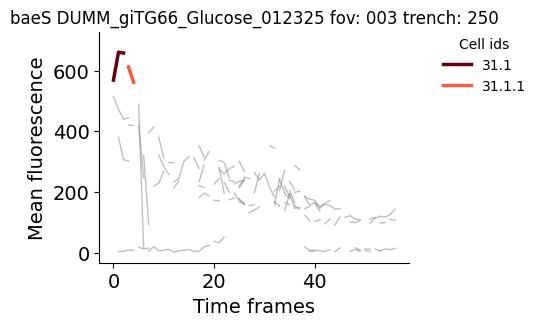

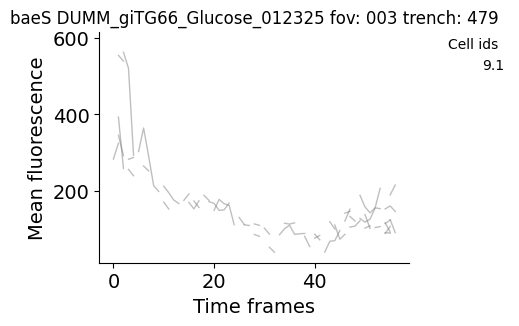

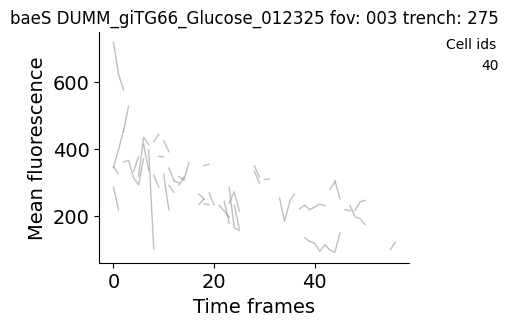

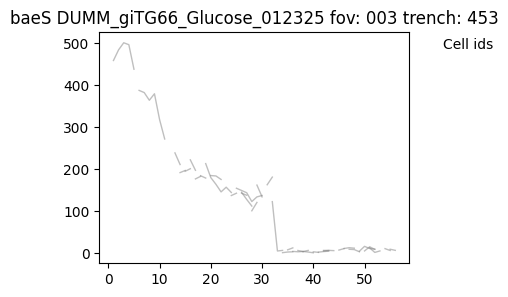

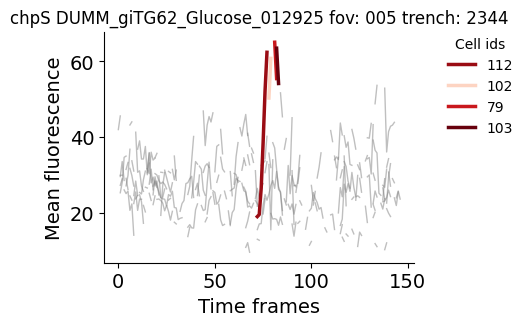

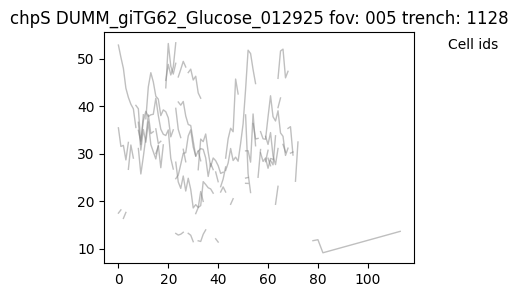

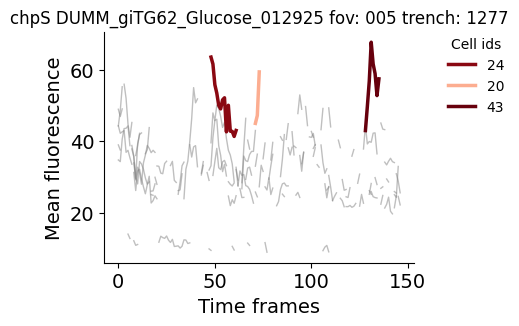

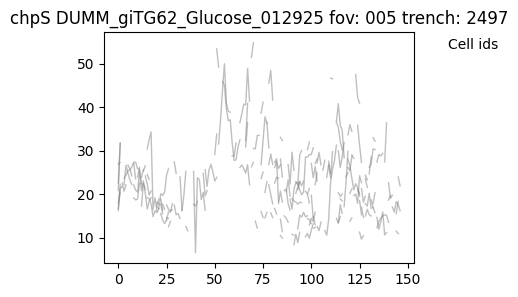

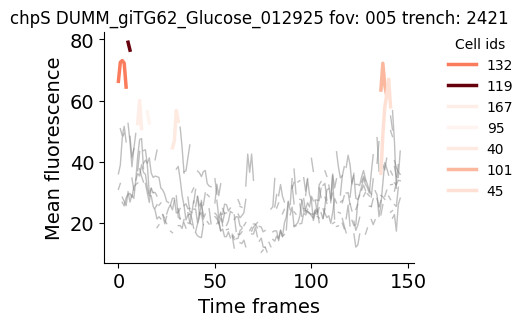

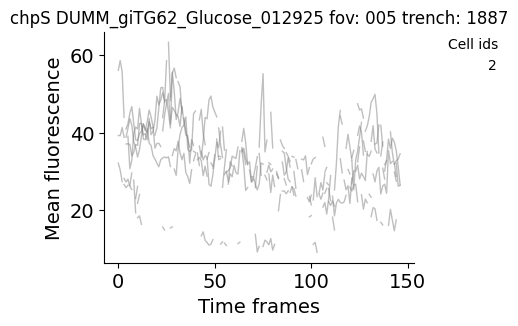

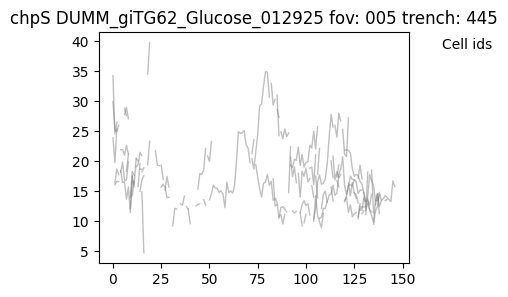

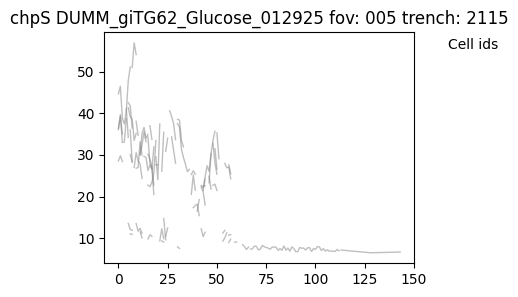

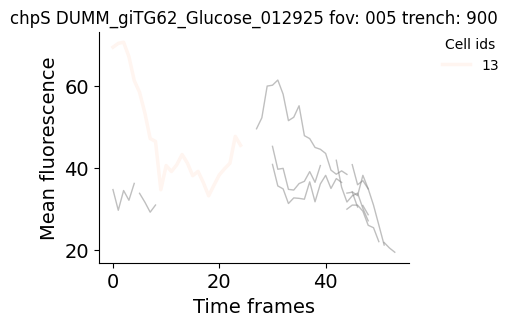

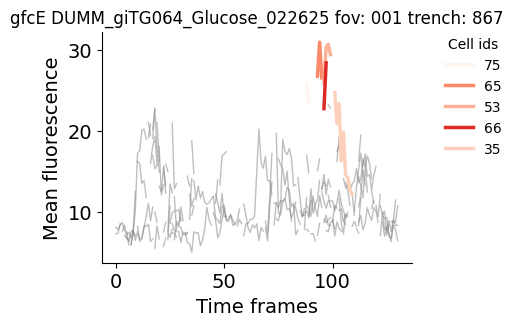

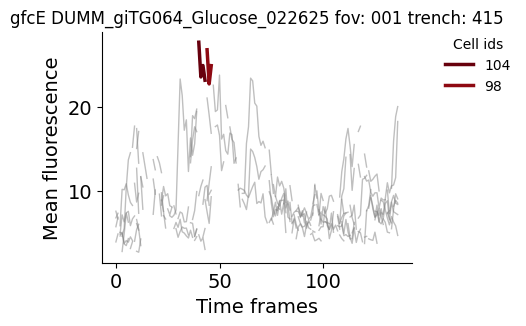

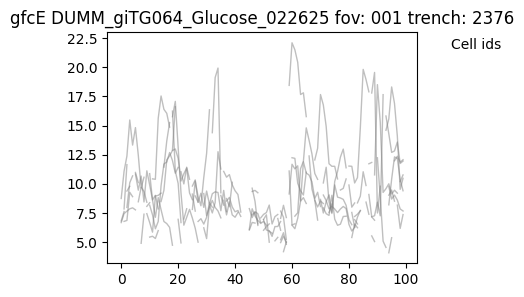

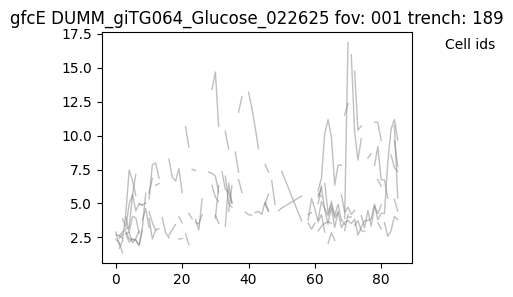

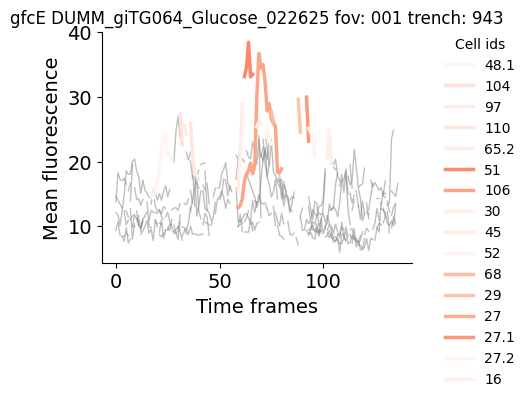

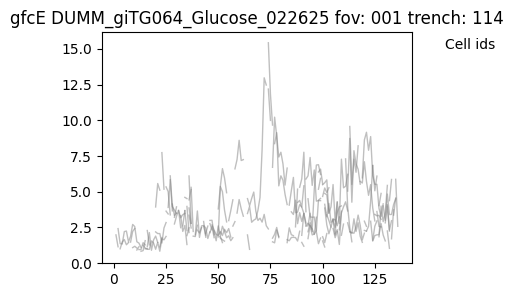

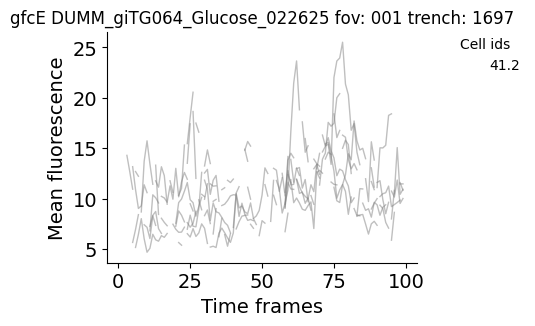

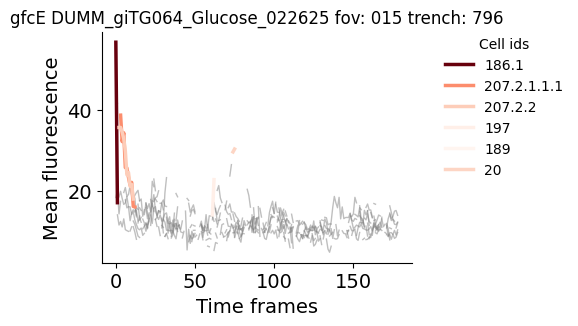

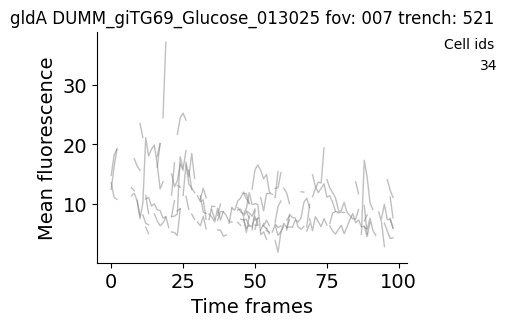

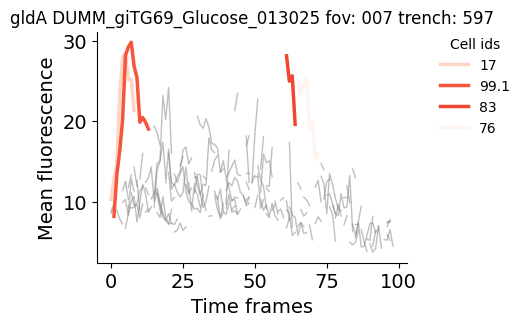

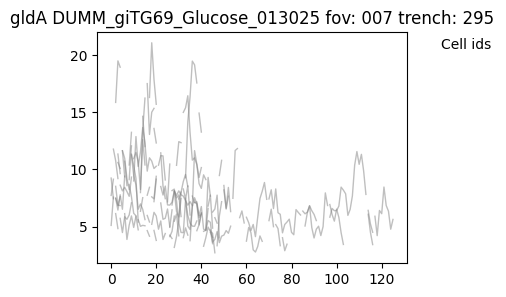

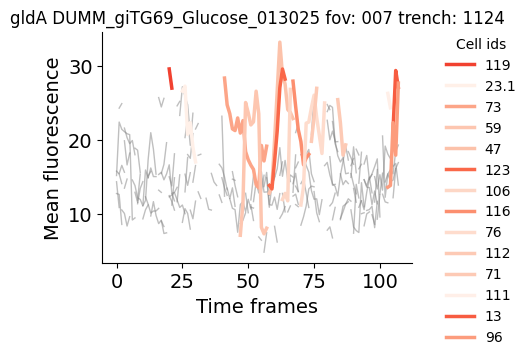

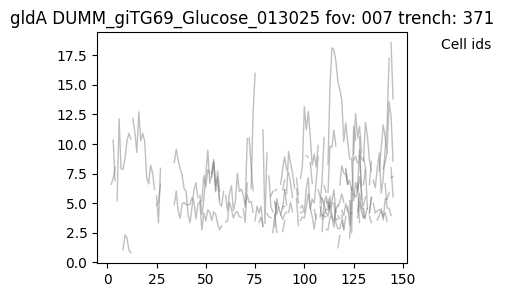

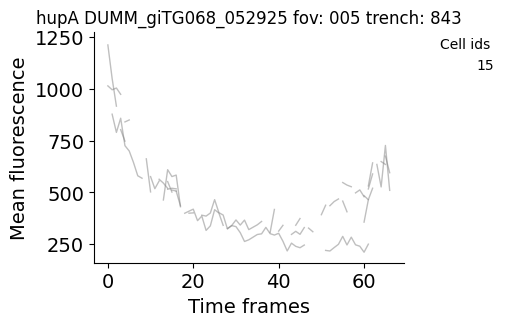

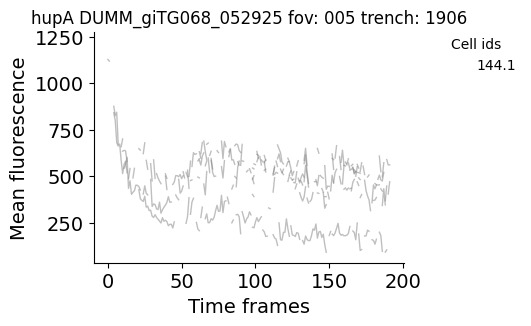

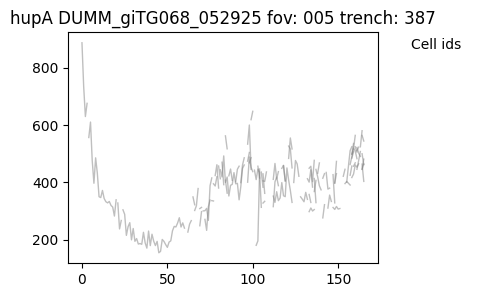

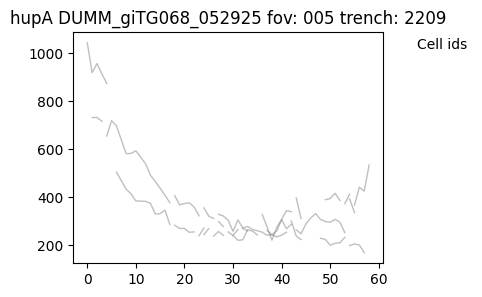

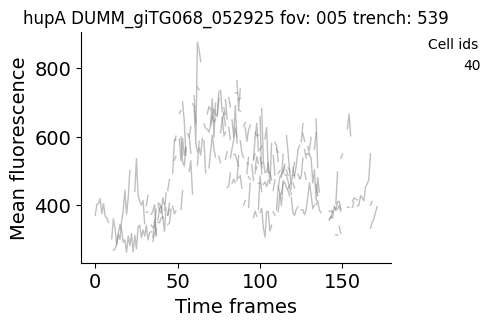

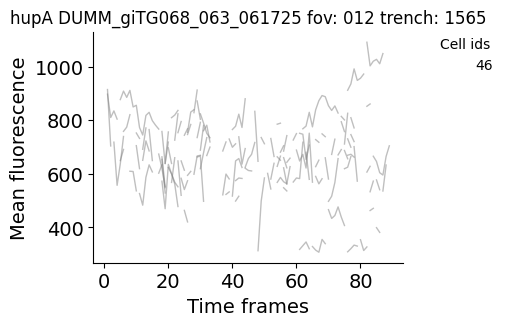

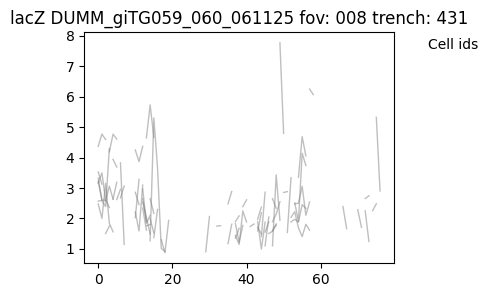

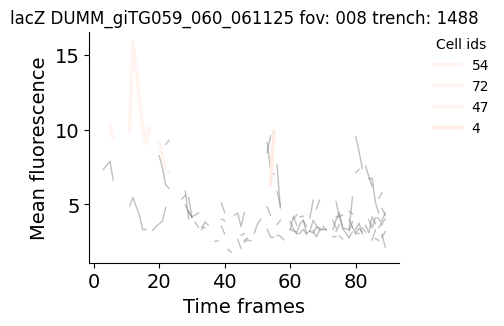

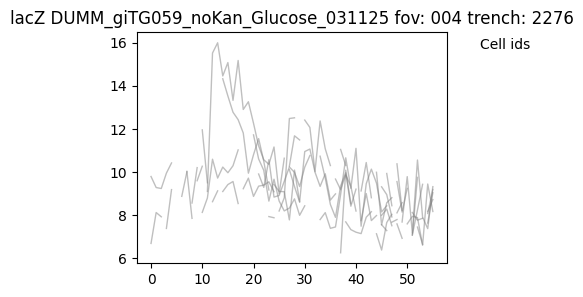

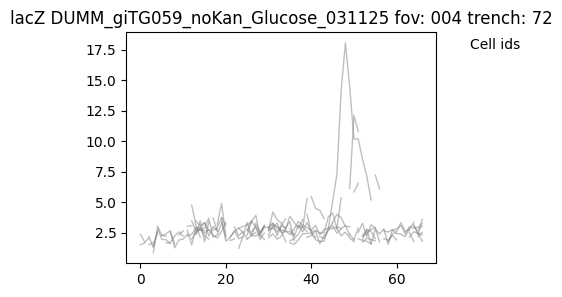

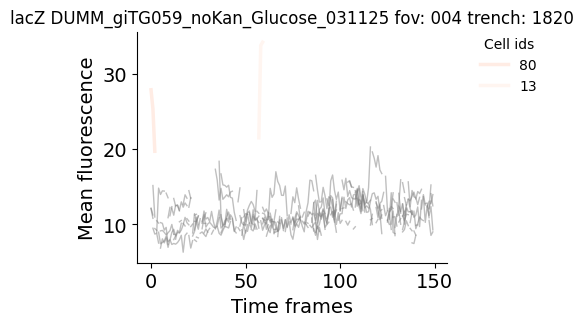

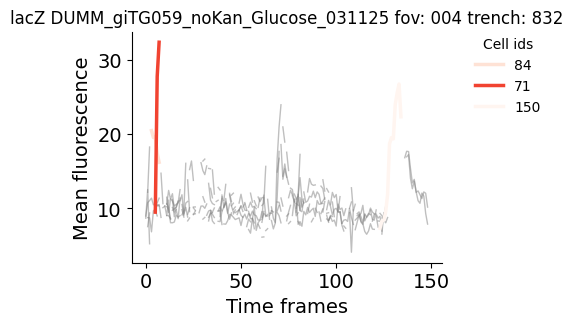

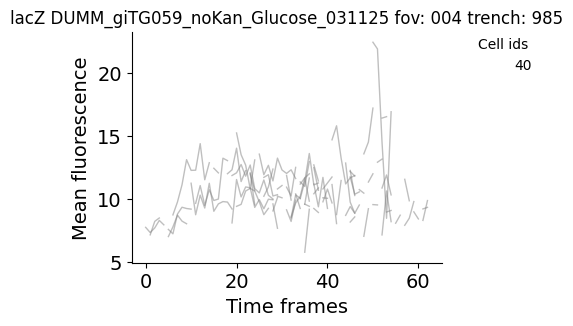

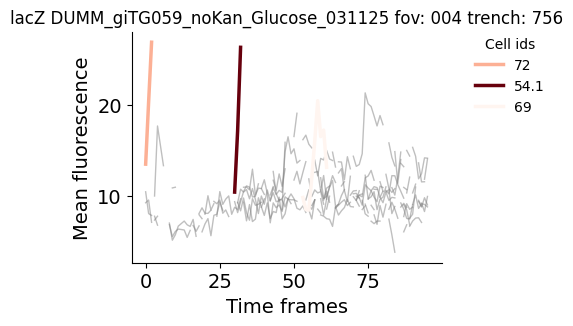

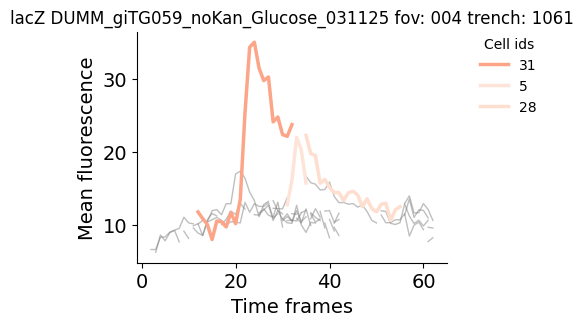

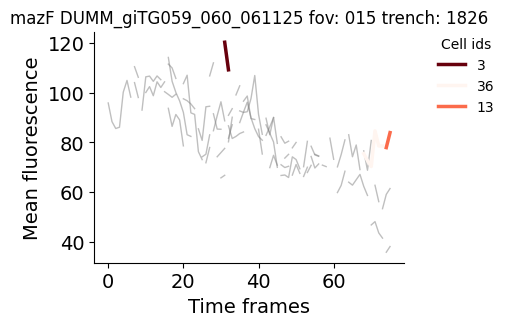

In [68]:
unique_fovs = bursts_all_lineages_df[['gene','experiment_name', 'FOV', 'trench_id']].drop_duplicates().to_records(index=False)

cell_color_dict = {}
for cell_info in unique_fovs:
    gene, exp, fov, trench = cell_info
    trench_df = bursts_all_lineages_df[
        (bursts_all_lineages_df['gene'] == gene) & 
        (bursts_all_lineages_df['experiment_name'] == exp) &
        (bursts_all_lineages_df['FOV'] == fov) &
        (bursts_all_lineages_df['trench_id'] == trench)
        ]
    
    plt.figure(figsize=(4, 3))
    
    for cell_id in trench_df['predicted_lineage'].unique():
        subset = trench_df[trench_df['predicted_lineage'] == cell_id].sort_values(by='time_frame')
        plt.plot(subset['time_frame'], subset['intensity_mean_fluor'], color='gray', alpha=0.5, linewidth=1)
    
    # Plot the specific line to be colored
    local_peaks = trench_df[trench_df['is_burst']]
    cmap = plt.cm.get_cmap('Reds')
    highlighted_cell_ids =  local_peaks['predicted_lineage'].unique()
    for cell_id_color in highlighted_cell_ids:
        colored_cell = trench_df[trench_df['predicted_lineage'] == cell_id_color].sort_values(by='time_frame')
        peak_score = local_peaks[local_peaks['predicted_lineage'] == cell_id_color]['normalized_fluorescence'].values[0]
        norm_score = (peak_score - local_peaks['normalized_fluorescence'].min()) / (local_peaks['normalized_fluorescence'].max() - local_peaks['normalized_fluorescence'].min())
        line_color = cmap(norm_score)
        cell_color_dict[cell_id_color] = line_color

        plt.plot(colored_cell['time_frame'], colored_cell['intensity_mean_fluor'], linewidth=2.5, color=line_color, label=cell_id_color)
        sns.despine();
        plt.xlabel('Time frames', fontsize=14)
        plt.ylabel('Mean fluorescence', fontsize=14)
        plt.tick_params(axis='x', labelsize=14)
        plt.tick_params(axis='y', labelsize=14)

    plt.legend(bbox_to_anchor=(1.09, 1), loc='upper left', borderaxespad=0, frameon= False, title = 'Cell ids')
    plt.title(f'{gene} {exp} fov: {fov} trench: {trench}')

In [69]:
counts_per_lineage = bursts_all_lineages_df[~bursts_all_lineages_df['ground_truth_lineage'].isna()].groupby(['gene', 'experiment_name', 'FOV', 'trench_id', 'ground_truth_lineage']).size()

time_frames_per_avg_cell_cycle = counts_per_lineage.groupby(['gene', 'experiment_name']).mean().reset_index().rename(columns={0: 'average_frame_count'})

In [70]:
time_frames_per_avg_cell_cycle

,gene,experiment_name,average_frame_count
0,baeS,DUMM_giTG66_Glucose_012325,9.166667
1,chpS,DUMM_giTG62_Glucose_012925,10.166667
2,gfcE,DUMM_giTG064_Glucose_022625,8.603448
3,gldA,DUMM_giTG69_Glucose_013025,10.963636
4,hupA,DUMM_giTG068_052925,11.750000
5,hupA,DUMM_giTG068_063_061725,5.166667
6,lacZ,DUMM_giTG059_noKan_Glucose_031125,9.956522
7,mazF,DUMM_giTG059_060_061125,4.871795


In [43]:
# First, calculate the number of peaks and unique cells for each gene/experiment combo.
grouped_data = bursts_all_lineages_df.groupby(['gene', 'experiment_name']).agg(
    num_peaks=('is_burst', 'sum'),  # Summing boolean 'is_burst' counts the True values
    num_cell_images=('node_id', pd.Series.nunique)
).reset_index()

# Second, merge this with the cell cycle length data
peak_freq_df = pd.merge(grouped_data, time_frames_per_avg_cell_cycle,
                        on=['gene', 'experiment_name'])
# Third, perform the final calculation
peak_freq_df['peak_frequency'] = (peak_freq_df['num_peaks'] / peak_freq_df['num_cell_images']) * peak_freq_df['average_frame_count']
avg_peak_freq_per_gene = peak_freq_df.groupby('gene')['peak_frequency'].mean().reset_index()

In [54]:
peak_freq_df

,gene,experiment_name,num_peaks,num_cell_images,average_frame_count,peak_frequency
0,alkA,DUMM_giTG068_063_061725_v2,6,684,4.272727,0.037480
1,alkA,DUMM_giTG63_giTG67_Glucose_121724_1_v2,19,1446,9.200000,0.120885
2,baeS,DUMM_giTG66_Glucose_012325,9,864,9.166667,0.095486
3,chpS,DUMM_giTG62_Glucose_012925,28,3684,10.166667,0.077271
4,gfcE,DUMM_giTG064_Glucose_022625,49,4722,8.603448,0.089278
5,gldA,DUMM_giTG69_Glucose_013025,34,2232,10.963636,0.167009
6,hupA,DUMM_giTG068_052925,6,1711,11.750000,0.041204
7,hupA,DUMM_giTG068_063_061725,2,753,5.166667,0.013723
8,lacZ,DUMM_giTG059_noKan_Glucose_031125,33,3033,9.956522,0.108330
9,mazF,DUMM_giTG059_060_061125,7,605,4.871795,0.056368


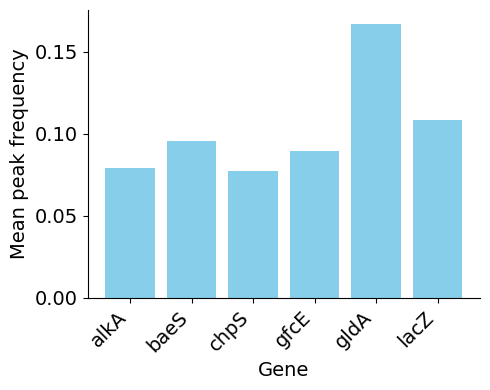

In [52]:
peaks_to_plot = avg_peak_freq_per_gene[~avg_peak_freq_per_gene['gene'].isin(['mazF', 'hupA'])]
plt.figure(figsize=(5, 4))
plt.bar(peaks_to_plot['gene'], peaks_to_plot['peak_frequency'], color='skyblue')

# Add labels and a title for clarity
plt.xlabel('Gene', fontsize=14)
plt.ylabel('Mean peak frequency', fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust plot to ensure everything fits
sns.despine();

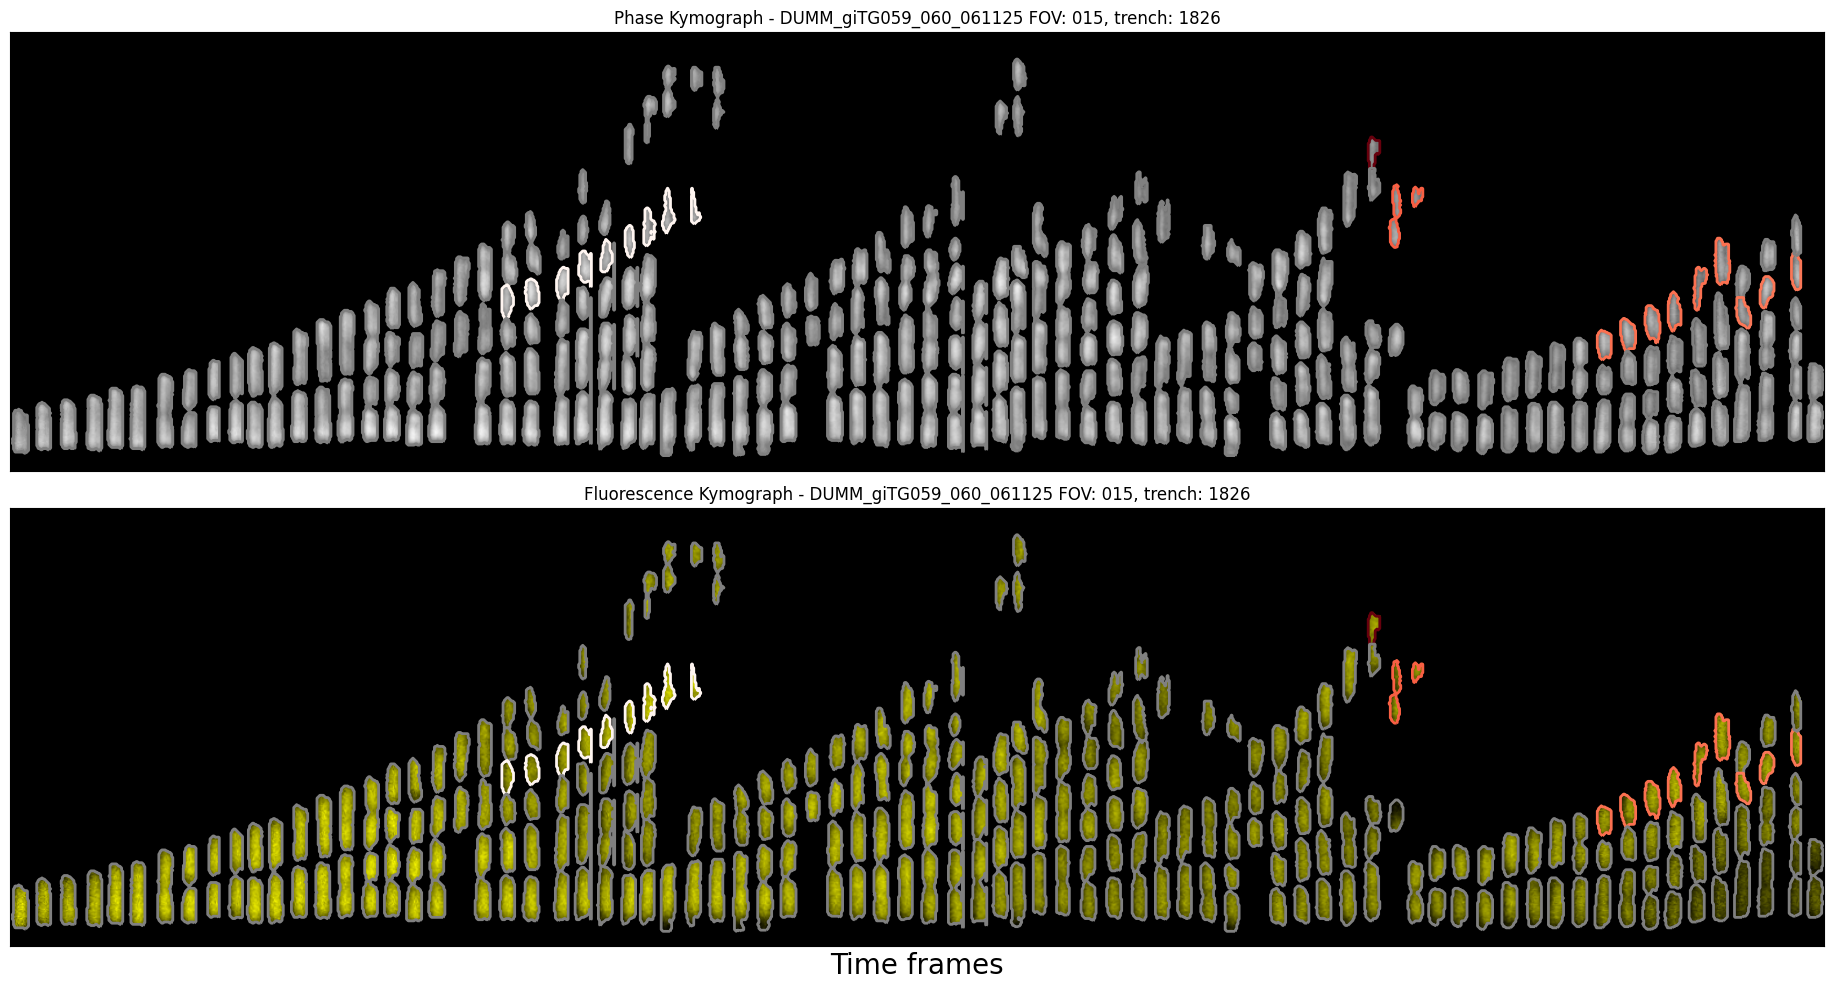

In [189]:
for cell_info in unique_fovs:
    exp_view, fov_view, trench_view = cell_info

    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'
    
    
    path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
    path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'

    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/kymographs/phase/{fov_view}_{trench_view}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//kymographs/fluor/{fov_view}_{trench_view}.tif'

    # Check if both Tiff files exist before reading them and proceeding
    if os.path.exists(path_to_phase_kymograph) and os.path.exists(path_to_fluor_kymograph):
        phase_kymograph = tifffile.imread(path_to_phase_kymograph)
        fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)

        all_cells_to_view_df = gene_df.copy()
        plot_kymograph_cells_interest(phase_kymograph, fluor_kymograph, 
                                            gene_df, 
                                            exp_view, fov_view, trench_view, 
                                            track_id_col='ground_truth_lineage', cell_id_to_color=cell_color_dict)